In [1]:
import os
import datautil
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [2]:
projects = datautil.select_projects_from_libraries_io()
libraries = datautil.select_libraries()
migrations = datautil.select_migrations()
lib_names = set(libraries["name"])
rules = datautil.select_rules(lib_names)
dep_changes = datautil.select_dependency_changes_all(lib_names)
print(f"{len(projects)} projects, {len(libraries)} libraries, {len(dep_changes)} dep changes")

19652 projects, 4022 libraries, 3328884 dep changes


In [3]:
dep_changes.head()

,project,commit,file,type,lib1,lib2,ver1,ver2
0,Snailclimb/JavaGuide,e8aeaef43cbfb2b8a9b71c7b7f462c48b4adb9a6,docs/dataStructures-algorithms/source code/sec...,add,,commons-codec:commons-codec,,1.8
1,Snailclimb/JavaGuide,e8aeaef43cbfb2b8a9b71c7b7f462c48b4adb9a6,docs/dataStructures-algorithms/source code/sec...,add,,junit:junit,,4.12
2,Snailclimb/JavaGuide,e8aeaef43cbfb2b8a9b71c7b7f462c48b4adb9a6,docs/dataStructures-algorithms/source code/sec...,add,,org.bouncycastle:bcprov-jdk15on,,1.56
3,Snailclimb/JavaGuide,a17a2800c92f918842d26a9e9261ae0bba89286d,数据结构与算法/source code/securityAlgorithm/pom.xml,add,,commons-codec:commons-codec,,1.8
4,Snailclimb/JavaGuide,a17a2800c92f918842d26a9e9261ae0bba89286d,数据结构与算法/source code/securityAlgorithm/pom.xml,add,,junit:junit,,3.8.1


In [4]:
proj2commits = dict(zip(projects.nameWithOwner, projects.commitsCount))
rule_set = set(zip(rules.fromLib, rules.toLib))
proj_stats = dict()
for proj, df in dep_changes.groupby(["project"]):
    proj_stats[proj] = {
        "project": proj,
        "changes": len(df),
        "adoptions": len(df[df.type == "add"]),
        "removals": len(df[df.type == "rem"]),
        "verchgs": len(df[df.type == "verchg"]),
        "commits": proj2commits[proj],
        "change_commits": len(set(df.commit)),
        "adoption_commits": len(set(df[df.type == "add"].commit)),
        "removal_commits": len(set(df[df.type == "rem"].commit)),
        "verchg_commits": len(set(df[df.type == "verchg"].commit)),
        "possible_migrations": 0,
        "confirmed_migrations": 0
    }
    for path, df2 in df.groupby(["file"]):
        for added_lib, removed_lib in itertools.product(set(df2.lib2), set(df2.lib1)):
            if (removed_lib, added_lib) in rule_set:
                proj_stats[proj]["possible_migrations"] += 1
for idx, row in migrations.iterrows():
    if row["repoName"].replace("_", "/") not in proj_stats:
        continue
    proj_stats[row["repoName"].replace("_", "/")]["confirmed_migrations"] += 1
proj_stats = pd.DataFrame(proj_stats.values())
proj_stats.head()

,project,changes,adoptions,removals,verchgs,commits,change_commits,adoption_commits,removal_commits,verchg_commits,possible_migrations,confirmed_migrations
0,01org/graphbuilder,37,32,1,4,62,3,3,1,2,2,0
1,07kit/07kit,20,20,0,0,45,2,2,0,0,0,0
2,0ang3el/HQLi-playground,1,1,0,0,5,1,1,0,0,0,0
3,0nise/shell-plus,1,1,0,0,8,1,1,0,0,0,0
4,0opslab/opslabJutil,15,10,3,2,364,4,2,2,1,1,0


In [5]:
def percent(df, cond) -> str:
    return f"{len(df[cond])} / {len(df)} ({len(df[cond]) / len(df) * 100:.2f}%)"

print("For all projects:")
print(f"{percent(proj_stats, proj_stats.adoptions != 0)} projects with at least one library adoption")
print(f"{percent(proj_stats, proj_stats.removals != 0)} projects with at least one library removal")
print(f"{percent(proj_stats, proj_stats.verchgs != 0)} projects with at least one version change")
print(f"{percent(proj_stats, proj_stats.possible_migrations != 0)} projects with at least one possible migration")
print(f"{percent(proj_stats, proj_stats.confirmed_migrations != 0)} projects with at least one confirmed migration")

For all projects:
18583 / 18912 (98.26%) projects with at least one library adoption
8583 / 18912 (45.38%) projects with at least one library removal
9404 / 18912 (49.73%) projects with at least one version change
5145 / 18912 (27.20%) projects with at least one possible migration
1592 / 18912 (8.42%) projects with at least one confirmed migration


In [6]:
splits = np.array_split(proj_stats.sort_values(by="commits"), 5)[-1]
print("For the 20% projects with most commits:")
print(f"{percent(splits, splits.adoptions != 0)} projects with at least one library adoption")
print(f"{percent(splits, splits.removals != 0)} projects with at least one library removal")
print(f"{percent(splits, splits.verchgs != 0)} projects with at least one version change")
print(f"{percent(splits, splits.possible_migrations != 0)} projects with at least one possible migration")
print(f"{percent(splits, splits.confirmed_migrations != 0)} projects with at least one confirmed migration")

For the 20% projects with most commits:
3746 / 3782 (99.05%) projects with at least one library adoption
2976 / 3782 (78.69%) projects with at least one library removal
2987 / 3782 (78.98%) projects with at least one version change
2225 / 3782 (58.83%) projects with at least one possible migration
1029 / 3782 (27.21%) projects with at least one confirmed migration


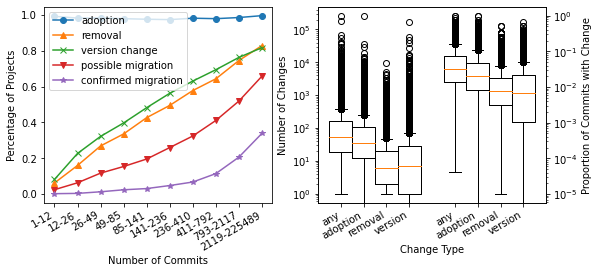

In [7]:
splits = np.array_split(proj_stats.sort_values(by="commits"), 10)
ranges = list(map(lambda x: f"{min(x.commits)}-{max(x.commits)}", splits))
adt_rate = list(map(lambda x: len(x[x.adoptions != 0]) / len(x), splits))
rem_rate = list(map(lambda x: len(x[x.removals != 0]) / len(x), splits))
ver_rate = list(map(lambda x: len(x[x.verchgs != 0]) / len(x), splits))
posmig_rate = list(map(lambda x: len(x[x.possible_migrations != 0]) / len(x), splits))
conmig_rate = list(map(lambda x: len(x[x.confirmed_migrations != 0]) / len(x), splits))
proj_stats_f = proj_stats[proj_stats.removals != 0].copy()

fig, axes = plt.subplots(1, 2, figsize=(9,4))
axes[0].plot(ranges, adt_rate, marker="o", label="adoption")
axes[0].plot(ranges, rem_rate, marker="^", label="removal")
axes[0].plot(ranges, ver_rate, marker="x", label="version change")
axes[0].plot(ranges, posmig_rate, marker="v", label="possible migration")
axes[0].plot(ranges, conmig_rate, marker="*", label="confirmed migration")
axes[0].set_xlabel("Number of Commits")
axes[0].set_ylabel("Percentage of Projects")
axes[0].legend()

axes[1].boxplot(x=[
    proj_stats_f.changes,
    proj_stats_f.adoptions,
    proj_stats_f.removals,
    proj_stats_f.verchgs,
    ],
    labels=["any", "adoption", "removal", "version"], 
    positions=[0,0.5,1,1.5], widths=0.5)
axes[1].set_yscale("log")
axes[1].set_ylabel("Number of Changes")
axes[1].set_xlabel("Change Type")
ax2 = axes[1].twinx()
ax2.boxplot(x=[
    proj_stats_f.change_commits / proj_stats_f.commits,
    proj_stats_f.adoption_commits / proj_stats_f.commits,
    proj_stats_f.removal_commits / proj_stats_f.commits,
    proj_stats_f.verchg_commits / proj_stats_f.commits,
    ], labels=["any", "adoption", "removal", "version"], positions=[2.5,3,3.5,4], widths=0.5)
ax2.set_yscale("log")
ax2.set_ylabel("Proportion of Commits with Change")

fig.autofmt_xdate()
fig.savefig("plots/depchgs.pdf", bbox_inches="tight")

In [8]:
proj_stats_f["commit_portion_c"] = proj_stats_f.change_commits / proj_stats_f.commits
proj_stats_f["commit_portion_a"] = proj_stats_f.adoption_commits / proj_stats_f.commits
proj_stats_f["commit_portion_r"] = proj_stats_f.removal_commits / proj_stats_f.commits
proj_stats_f["commit_portion_v"] = proj_stats_f.verchg_commits / proj_stats_f.commits
proj_stats_f[["changes", "adoptions", "removals", "verchgs", "commit_portion_c", "commit_portion_a", "commit_portion_r", "commit_portion_v"]].describe()

,changes,adoptions,removals,verchgs,commit_portion_c,commit_portion_a,commit_portion_r,commit_portion_v
count,8583.000000,8583.000000,8583.000000,8583.000000,8583.000000,8583.000000,8583.000000,8583.000000
mean,364.892345,207.334731,38.215892,119.341722,0.060243,0.043146,0.016609,0.019293
std,3830.064970,2927.811213,190.962513,2189.013558,0.080220,0.066868,0.029031,0.037184
min,1.000000,0.000000,1.000000,0.000000,0.000042,0.000000,0.000010,0.000000
25%,19.000000,12.000000,2.000000,1.000000,0.013699,0.008277,0.003058,0.001055
50%,55.000000,34.000000,6.000000,7.000000,0.032787,0.020725,0.007576,0.006792
75%,165.000000,107.000000,20.000000,28.000000,0.072000,0.048027,0.017857,0.020984
max,263183.000000,260091.000000,9299.000000,174325.000000,1.000000,1.000000,0.500000,0.655709


In [9]:
proj_stats_f["retention"] = 1 - proj_stats_f.removals / np.maximum(1, proj_stats_f.adoptions)
proj_stats_f["retention"].describe()

count    8583.000000
mean        0.649882
std         0.867581
min       -48.666667
25%         0.601996
50%         0.785714
75%         0.896639
max         0.999084
Name: retention, dtype: float64

In [10]:
lib_retention = defaultdict(lambda: [0, 0])
for type, lib1, lib2 in zip(dep_changes.type, dep_changes.lib1, dep_changes.lib2):
    if type == "add":
        lib_retention[lib2][1] += 1
    elif type == "rem":
        lib_retention[lib1][0] += 1
libraries["retention"] = libraries.name.map(lambda n: 1 - lib_retention[n][0] / max(1, lib_retention[n][1]))
libraries[libraries.name.isin(dep_changes["lib2"])]["retention"].describe()

count    4022.000000
mean        0.751264
std         0.219149
min        -2.391304
25%         0.694600
50%         0.801887
75%         0.871035
max         1.000000
Name: retention, dtype: float64

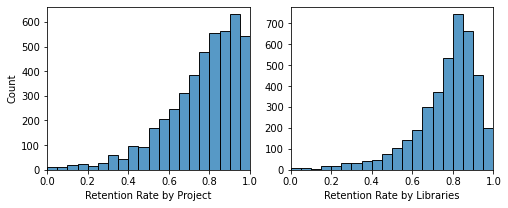

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8,3))
sns.histplot(data=proj_stats_f[proj_stats_f["change_commits"] >= 10], x="retention", binwidth=0.05, binrange=(0, 1), ax=axes[0])
axes[0].set_xlabel("Retention Rate by Project")
axes[0].set_xlim(0, 1)
sns.histplot(data=libraries[libraries.name.isin(dep_changes["lib2"])], x="retention", binwidth=0.05, binrange=(0, 1), ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_xlabel("Retention Rate by Libraries")
axes[1].set_xlim(0, 1)
fig.savefig("plots/retention.pdf", bbox_inches="tight")